In [22]:
import sys
import os

In [23]:
ROOT_PATH = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(ROOT_PATH, "data")
MODELS_PATH = os.path.join(ROOT_PATH, "models")
YOLOV7_PATH = os.path.join(ROOT_PATH, "yolov7")
sys.path.append(YOLOV7_PATH)

In [24]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
from torchvision import transforms
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

%matplotlib ipympl

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weigths = torch.load(os.path.join(MODELS_PATH, 'yolov7.pt'))
model = weigths['model']
model = model.half().to(device)
_ = model.eval()

In [26]:
model.yaml

{'nc': 80,
 'depth_multiple': 1.0,
 'width_multiple': 1.0,
 'anchors': [[12, 16, 19, 36, 40, 28],
  [36, 75, 76, 55, 72, 146],
  [142, 110, 192, 243, 459, 401]],
 'backbone': [[-1, 1, 'Conv', [32, 3, 1]],
  [-1, 1, 'Conv', [64, 3, 2]],
  [-1, 1, 'Conv', [64, 3, 1]],
  [-1, 1, 'Conv', [128, 3, 2]],
  [-1, 1, 'Conv', [64, 1, 1]],
  [-2, 1, 'Conv', [64, 1, 1]],
  [-1, 1, 'Conv', [64, 3, 1]],
  [-1, 1, 'Conv', [64, 3, 1]],
  [-1, 1, 'Conv', [64, 3, 1]],
  [-1, 1, 'Conv', [64, 3, 1]],
  [[-1, -3, -5, -6], 1, 'Concat', [1]],
  [-1, 1, 'Conv', [256, 1, 1]],
  [-1, 1, 'MP', []],
  [-1, 1, 'Conv', [128, 1, 1]],
  [-3, 1, 'Conv', [128, 1, 1]],
  [-1, 1, 'Conv', [128, 3, 2]],
  [[-1, -3], 1, 'Concat', [1]],
  [-1, 1, 'Conv', [128, 1, 1]],
  [-2, 1, 'Conv', [128, 1, 1]],
  [-1, 1, 'Conv', [128, 3, 1]],
  [-1, 1, 'Conv', [128, 3, 1]],
  [-1, 1, 'Conv', [128, 3, 1]],
  [-1, 1, 'Conv', [128, 3, 1]],
  [[-1, -3, -5, -6], 1, 'Concat', [1]],
  [-1, 1, 'Conv', [512, 1, 1]],
  [-1, 1, 'MP', []],
  [-1, 1,

In [27]:
# Hack to torch 1.13.1
import torch.nn as nn

for m in model.modules():
    if isinstance(m, nn.Upsample):
        m.recompute_scale_factor = None

In [43]:
left_test_image = cv2.imread(os.path.join(DATA_PATH, "keparoi_left_frame.jpg"))
right_test_image = cv2.imread(os.path.join(DATA_PATH, "keparoi_right_frame.jpg"))

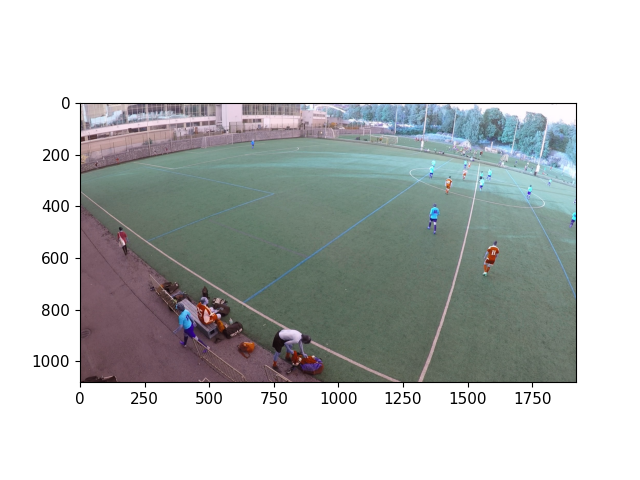

In [29]:
plt.imshow(left_test_image)
plt.show()

In [41]:
def detect(orig_image):
    frame_width = orig_image.shape[1]
    frame_height = orig_image.shape[0]
    
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    image = letterbox(image, (frame_width), stride=64, auto=True)[0]
    image_ = image.copy()
    image = transforms.ToTensor()(image)
    image = torch.tensor(np.array([image.numpy()]))
    image = image.to(device)
    image = image.half()

    with torch.no_grad():
        output, _ = model(image)

    output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'])
    output = output_to_keypoint(output)
    nimg = image[0].permute(1, 2, 0) * 255
    nimg = nimg.cpu().numpy().astype(np.uint8)
    nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
    
    n_players = 0
    
    for idx in range(output.shape[0]):

        class_id = output[idx][1]
        confidence = output[idx][6]

        if class_id != 0:
            continue

        if confidence < 0.7:
            continue

        xmin, ymin = (output[idx, 2]-output[idx, 4]/2), (output[idx, 3]-output[idx, 5]/2)
        xmax, ymax = (output[idx, 2]+output[idx, 4]/2), (output[idx, 3]+output[idx, 5]/2)
        cv2.rectangle(
          nimg,
          (int(xmin), int(ymin)),
          (int(xmax), int(ymax)),
          color=(255, 0, 0),
          thickness=1,
          lineType=cv2.LINE_AA
        )
        
        n_players +=1
        
    print(f"Detected {n_players} players")

    plt.imshow(nimg)
    plt.show()

Detected 15 players


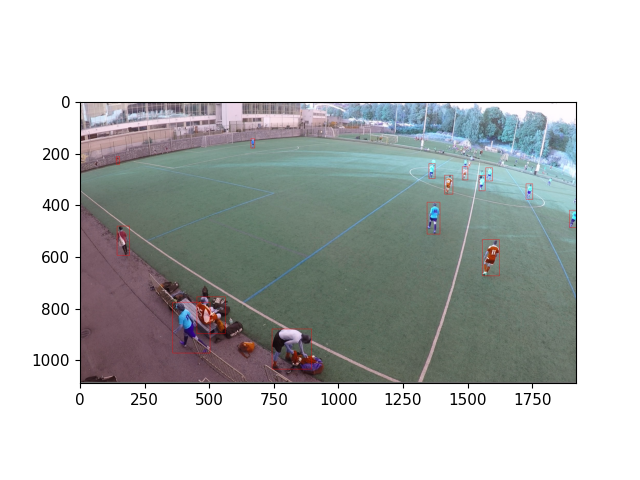

In [42]:
detect(left_test_image)

Detected 18 players


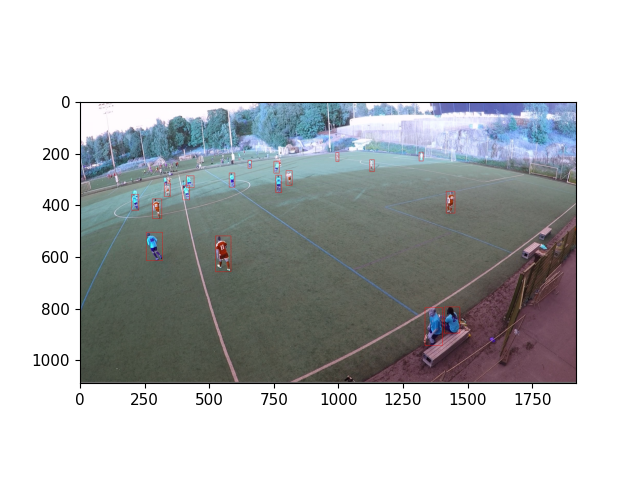

In [44]:
detect(right_test_image)